ETL

In [1]:
import re
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from summarytools import dfSummary
import contextily as ctx

In [2]:
data = pd.read_excel('Datasets\homicidios.xlsx')
homicides_facts = pd.read_excel('Datasets\homicidios.xlsx', sheet_name="HECHOS")
homicides_victims = pd.read_excel('Datasets\homicidios.xlsx', sheet_name="VICTIMAS")
communes= pd.read_excel('Datasets\comunas.xlsx')


# ETL
Treatment of data from the "homicides_facts" dataset.

In [3]:
homicides_facts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     696 non-null    object        
 1   N_VICTIMAS             696 non-null    int64         
 2   FECHA                  696 non-null    datetime64[ns]
 3   AAAA                   696 non-null    int64         
 4   MM                     696 non-null    int64         
 5   DD                     696 non-null    int64         
 6   HORA                   696 non-null    object        
 7   HH                     696 non-null    object        
 8   LUGAR_DEL_HECHO        696 non-null    object        
 9   TIPO_DE_CALLE          696 non-null    object        
 10  Calle                  695 non-null    object        
 11  Altura                 129 non-null    float64       
 12  Cruce                  525 non-null    object        
 13  Direc

In [4]:
homicides_facts.isnull().sum()

ID                         0
N_VICTIMAS                 0
FECHA                      0
AAAA                       0
MM                         0
DD                         0
HORA                       0
HH                         0
LUGAR_DEL_HECHO            0
TIPO_DE_CALLE              0
Calle                      1
Altura                   567
Cruce                    171
Dirección Normalizada      8
COMUNA                     0
XY (CABA)                  0
pos x                      0
pos y                      0
PARTICIPANTES              0
VICTIMA                    0
ACUSADO                    0
dtype: int64

We will removed the ‘Altura’ column due to its lack of relevance for our homicide analysis. Since height refers to the numbering of the street where the accident occurs and most cases occur at intersections or corners. This will allow us to work with cleaner and more accurate data. It has 567 nulls that represent 81.5% of the data in the column.

In [5]:
# Remove the 'Altura' column
homicides_facts= homicides_facts.drop("Altura", axis=1)
homicides_facts.columns

Index(['ID', 'N_VICTIMAS', 'FECHA', 'AAAA', 'MM', 'DD', 'HORA', 'HH',
       'LUGAR_DEL_HECHO', 'TIPO_DE_CALLE', 'Calle', 'Cruce',
       'Dirección Normalizada', 'COMUNA', 'XY (CABA)', 'pos x', 'pos y',
       'PARTICIPANTES', 'VICTIMA', 'ACUSADO'],
      dtype='object')

In [6]:
homicides_facts.duplicated().sum()

0

In this case, no duplicate data was found.

# Data transformation:

In [7]:
homicides_facts.head(5)

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,NaN,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.46503904,-34.68092974,MOTO-SD,MOTO,SD
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS


Column data types are regularized
The column that needs transformation is HH, because it is found as an object and should be numeric.
Therefore, the data in the column is analyzed and transformed into a numeric data type.

In [8]:
homicides_facts.rename(columns={'HH':'Hr'}, inplace=True)
homicides_facts["Hr"] = pd.to_numeric(homicides_facts["Hr"], errors="coerce")
homicides_facts["Hr"] = homicides_facts["Hr"].astype("Int64")
homicides_facts["Hr"].unique()

<IntegerArray>
[   4,    1,    7,    0,    5,   18,   19,   15,   11,   22,   16,    9,   23,
    6,   10,   17,   12,    8,   20,   21,   14,    3,    2,   13, <NA>]
Length: 25, dtype: Int64

Replace commas with periods and convert the values to floats in the ‘pos x’ and ‘pos y’. And replacing certain patterns in your DataFrame with specified values.

In [9]:
homicides_facts['pos x'] = pd.to_numeric(homicides_facts['pos x'], errors='coerce')
homicides_facts['pos y'] = pd.to_numeric(homicides_facts['pos y'], errors='coerce')

In [10]:
homicides_facts.replace(to_replace=['Ã‘', r'\?'], value=['Ñ', 'Ñ'], regex=True, inplace=True)
homicides_facts['FECHA'] = pd.to_datetime(homicides_facts['FECHA'], format='%Y-%m-%d')
homicides_facts.head(4)

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,Hr,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,NaN,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.465039,-34.680930,MOTO-SD,MOTO,SD


The ‘XY (CABA)’ column in the df_sinisters DataFrame encapsulates geographical coordinates, which are pivotal for spatial mapping. To utilize these coordinates, they must first be extracted and transformed into a more usable format.

A function is devised for this purpose, which accepts a string argument—presumably a pair of coordinates. The function employs a regular expression via the re.findall method to systematically identify all instances of decimal numbers within the input string. These decimal numbers, which represent the coordinates, are subsequently stored in a list.

The function then proceeds to return a tuple of two floating point numbers, which correspond to the ‘x’ and ‘y’ coordinates. This is achieved by converting the first two elements in the list of coordinates to floats. It’s worth noting that if the list contains less than two elements, this step would result in an error.

The function is then applied to each row in the ‘XY (CABA)’ column of df_sinisters using the .map() method. This operation extracts the ‘x’ and ‘y’ coordinates from each row and stores them in two separate lists.

Finally, the zip(*...) function is employed to unpack the lists of ‘x’ and ‘y’ coordinates. These unpacked lists are then used to create two new columns in the DataFrame: ‘x_coordinate’ and ‘y_coordinate’.

This process effectively transforms the coordinate data from a single string-based column into two float-based columns, thereby facilitating numerical operations and visualizations. This meticulous procedure underscores the importance of data transformation in enhancing the usability and accessibility of data.

In [11]:

def extract_coordinates(text):
    # Utilizamos una expresión regular para extraer las coordenadas
    coordinates = re.findall(r'\d+\.\d+', text)
    if len(coordinates) == 2:
        return float(coordinates[0]), float(coordinates[1])
    else:
        return None, None

# Aplicar la función a la columna 'XY (CABA)'
homicides_facts['coordenada_x'], homicides_facts['coordenada_y'] = zip(*homicides_facts['XY (CABA)'].map(extract_coordinates))

# Filtrar los registros que no tienen coordenadas válidas
homicides_facts = homicides_facts[(homicides_facts['coordenada_x'].notnull()) & (homicides_facts['coordenada_y'].notnull())]
homicides_facts["XY (CABA)"].head(4)

0     Point (98896.78238426 93532.43437792)
1     Point (95832.05571093 95505.41641999)
2    Point (106684.29090040 99706.57687843)
3     Point (99840.65224780 94269.16534422)
Name: XY (CABA), dtype: object

It is tested that there are no outliers in the coordinates. We proceed to ensure that all points are contained within CABA.

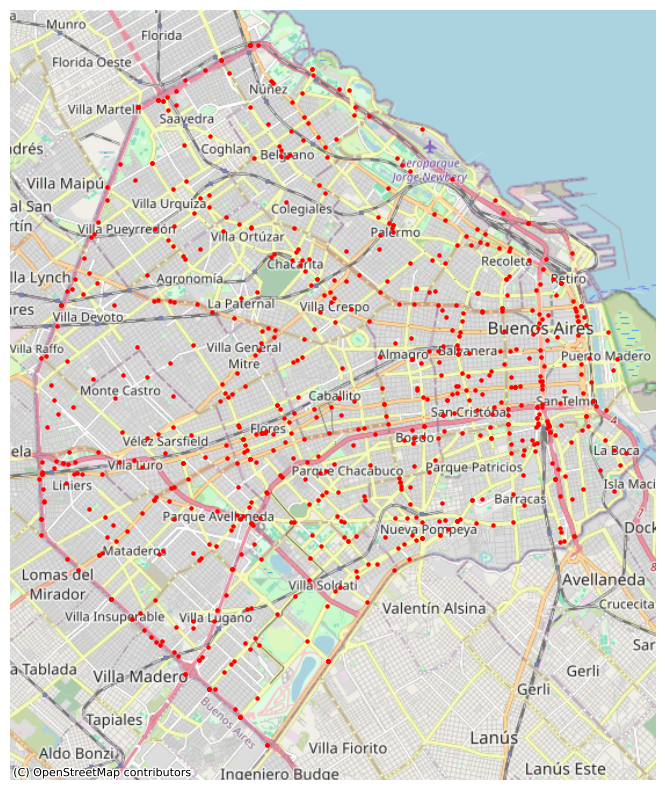

In [12]:
# Convert the DataFrame to a GeoDataFrame in WGS84 (lat/lon)
geodf_homicides = gpd.GeoDataFrame(
    homicides_facts, 
    geometry=gpd.points_from_xy(homicides_facts['pos x'], homicides_facts['pos y'])
)
geodf_homicides.crs = 'epsg:4326'  # Set coordinate reference system to WGS84

# Convert to Web Mercator for contextily basemap
geodf_homicides = geodf_homicides.to_crs(epsg=3857)

# Plotting with the basemap
ax = geodf_homicides.plot(marker='o', color='red', markersize=5, figsize=(10, 10))  # Adjust markersize as needed
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)  # Using OpenStreetMap.Mapnik as the basemap
ax.set_axis_off()
plt.show()

Capitalizing Column Names, replacing Underscores with Spaces AND renaming the DataFrame

In [13]:

homicides_facts.columns = [x.capitalize() for x in homicides_facts.columns]
homicides_facts.columns = homicides_facts.columns.str.replace("_", " ")
homicides_facts= homicides_facts.rename(columns={"N victimas": "Num victims",
                                        "Fecha" : "Date",  
                                        "Dd" : "Day",   
                                        "Hh": "Hr",
                                        "Lugar del hecho" :"Location of the event",
                                        "Tipo de calle" : "Street Tipe",
                                        "Calle" : "Street",
                                        "Cruce" : "Croos",
                                        "Dirección normalizada": "Normalized address",
                                        "Comuna": "Commune",
                                        "Xy (caba)" : "XY (CABA)",
                                        "Pos x" : "Pos X", 
                                        "Pos y" : "Pos Y",
                                        "Participantes" : "Participants",
                                        "Victima" : "Victim",
                                        "Acusado" : "Accused", 
                                        "Coordenada x" : "X coordinate", 
                                        "Coordenada y": "Y coordinate"}) 

homicides_facts.columns

Index(['Id', 'Num victims', 'Date', 'Aaaa', 'Mm', 'Day', 'Hora', 'Hr',
       'Location of the event', 'Street Tipe', 'Street', 'Croos',
       'Normalized address', 'Commune', 'XY (CABA)', 'Pos X', 'Pos Y',
       'Participants', 'Victim', 'Accused', 'X coordinate', 'Y coordinate'],
      dtype='object')

The Commune column is modified by adding the term Commune before the number, in order to achieve a categorical variable that simplifies the analysis. The merge is carried out through the common column `Commune` and `COMUNA`. The column `BARRIOS` renamed `Neighborhoods` will be attached. Info taken from: https://buenosaires.gob.ar/comunas

In [14]:
communes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   COMUNA   15 non-null     int64 
 1   BARRIOS  15 non-null     object
dtypes: int64(1), object(1)
memory usage: 372.0+ bytes


In [15]:
homicides_facts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 682 entries, 0 to 695
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Id                     682 non-null    object        
 1   Num victims            682 non-null    int64         
 2   Date                   682 non-null    datetime64[ns]
 3   Aaaa                   682 non-null    int64         
 4   Mm                     682 non-null    int64         
 5   Day                    682 non-null    int64         
 6   Hora                   682 non-null    object        
 7   Hr                     681 non-null    Int64         
 8   Location of the event  682 non-null    object        
 9   Street Tipe            682 non-null    object        
 10  Street                 682 non-null    object        
 11  Croos                  525 non-null    object        
 12  Normalized address     682 non-null    object        
 13  Commune   

In [16]:
communes['COMUNA'] = communes['COMUNA'].astype(str)
homicides_facts['Commune'] = homicides_facts['Commune'].astype(str)

In [17]:
# merge
Homicides = homicides_facts.merge(communes, left_on='Commune', right_on='COMUNA').drop(columns='COMUNA').rename(columns={'Commune': 'Commune'})

In [18]:
print(homicides_facts['Commune'].unique())
print(communes['COMUNA'].unique())

['8' '9' '1' '11' '15' '4' '7' '12' '3' '13' '14' '10' '6' '2' '5']
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15']


In [19]:
Homicides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Id                     682 non-null    object        
 1   Num victims            682 non-null    int64         
 2   Date                   682 non-null    datetime64[ns]
 3   Aaaa                   682 non-null    int64         
 4   Mm                     682 non-null    int64         
 5   Day                    682 non-null    int64         
 6   Hora                   682 non-null    object        
 7   Hr                     681 non-null    Int64         
 8   Location of the event  682 non-null    object        
 9   Street Tipe            682 non-null    object        
 10  Street                 682 non-null    object        
 11  Croos                  525 non-null    object        
 12  Normalized address     682 non-null    object        
 13  Commu

In [20]:
Homicides=Homicides.rename(columns={
    "BARRIOS": "Neighborhoods"
})
Homicides.head(2)
Homicides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Id                     682 non-null    object        
 1   Num victims            682 non-null    int64         
 2   Date                   682 non-null    datetime64[ns]
 3   Aaaa                   682 non-null    int64         
 4   Mm                     682 non-null    int64         
 5   Day                    682 non-null    int64         
 6   Hora                   682 non-null    object        
 7   Hr                     681 non-null    Int64         
 8   Location of the event  682 non-null    object        
 9   Street Tipe            682 non-null    object        
 10  Street                 682 non-null    object        
 11  Croos                  525 non-null    object        
 12  Normalized address     682 non-null    object        
 13  Commu

In [21]:
# Aplicar la función lambda a la columna 'Commune' del DataFrame
Homicides["Commune"] = Homicides["Commune"].apply(lambda x: "Commune "+x)

# Ahora puedes llamar a unique() sin problemas
print(Homicides["Commune"].unique())


['Commune 8' 'Commune 9' 'Commune 1' 'Commune 11' 'Commune 15' 'Commune 4'
 'Commune 7' 'Commune 12' 'Commune 3' 'Commune 13' 'Commune 14'
 'Commune 10' 'Commune 6' 'Commune 2' 'Commune 5']


Create a new column `Weekday` containing the name of the day of the week

In [22]:
Homicides.Day

0       1
1      10
2      24
3      15
4      28
       ..
677    10
678    11
679    21
680    14
681    22
Name: Day, Length: 682, dtype: int64

In [23]:
#Creo una columna nueva `Día semana` que contenga el nombre del día de la semana
Homicides['Weekday'] = Homicides['Date'].dt.strftime('%A')
Homicides['Weekday'].unique()

array(['Friday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Saturday',
       'Thursday'], dtype=object)

The decision has been made to eliminate the columns ‘AAAA’, ‘MM’, and ‘Hora’, as their information is already encapsulated within the ‘FECHA’ and ‘HH’ columns. The focus will be on time intervals, rendering minute-specific details unnecessary.

The columns ‘Location of the event’ and ‘Normalized address’ are also removed, as their data is contained within the ‘Street’ and ‘Croos’ columns. This step is taken to avoid redundancy and streamline the dataset.

Lastly, the ‘XY (CABA)’ column is eliminated, as the dataset already includes latitude and longitude data. This measure is taken to prevent data duplication and maintain a lean and efficient dataset.

Upon observing the potential relationship between the ‘Participantes’, ‘Víctima’, and ‘Acusado’ columns, a verification process was initiated. This process aimed to confirm whether the ‘Participantes’ column is indeed a composite of the ‘Víctima’ and ‘Acusado’ columns.

The verification process likely involved comparing the entries in the ‘Participantes’ column with corresponding entries in the ‘Víctima’ and ‘Acusado’ columns. This could be achieved through various methods, such as data comparison functions or conditional checks.
The verification confirmed the initial observation so it mean that the ‘Participantes’ column does not provide additional information beyond what is already contained in the ‘Víctims’ and ‘Accused’ columns. Consequently, this could influence decisions on data preprocessing, such as column selection or redundancy removal, enhancing the efficiency of subsequent data analysis and modeling stages.

These steps are crucial in data preprocessing, ensuring that the dataset is devoid of unnecessary or redundant information, thereby enhancing computational efficiency and data integrity. This meticulous approach underscores the importance of data cleaning in the data analysis pipeline.

In [24]:
Homicides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Id                     682 non-null    object        
 1   Num victims            682 non-null    int64         
 2   Date                   682 non-null    datetime64[ns]
 3   Aaaa                   682 non-null    int64         
 4   Mm                     682 non-null    int64         
 5   Day                    682 non-null    int64         
 6   Hora                   682 non-null    object        
 7   Hr                     681 non-null    Int64         
 8   Location of the event  682 non-null    object        
 9   Street Tipe            682 non-null    object        
 10  Street                 682 non-null    object        
 11  Croos                  525 non-null    object        
 12  Normalized address     682 non-null    object        
 13  Commu

In [25]:
drop_columns = ['Aaaa', 'Mm', 'Hora', 'Location of the event', 'Normalized address', 'XY (CABA)', 'Participants']
Homicides.drop(columns=drop_columns, inplace=True)

In [26]:
dfSummary(Homicides)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Id[object],1. 2016-00012. 2019-00873. 2017-01164. 2018-00135. 2018-00546. 2018-00887. 2018-01018. 2018-01209. 2018-012710. 2018-014211. other,1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)672 (98.5%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADXElEQVR4nO3cwWkbYRRG0TdGOPZGQhhcQtKDi0ixKUJFpAdjPIvY8WaySBYpINwB5ZwK/sWFh2A+Ldu2DRRu9n4A/w+xkREbGbGRERsZsZERGxmxkREbGbGRuVmW5cuyLHd7P4TrdzMzn2fm094P4fo5o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRG5mZmvs/Mz70fwvVb/IsRFWeUjNjIWFeRsa4i44ySERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZExeCFj8ELGGSUjNjIGL2QMXsg4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHFGyYiNjNjIWFeRsa4i44ySERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZGxriJjXUXGGSUjNjIGL2QMXsg4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZGxriJjXUXGGSUjNjLWVWSsq8g4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiMjNjLWVWSsq8g4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkXFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyy8zcz8zt3g/hqn1s2/Z2eHh4+Ho8Hs97v4brta7ry7Is3w7H4/H89PT0djqd3vd+FNfn9fX17nK5nJ+fn28PMzOn0+n98fHxx94P42rdz/iBQEhsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERuYw8/szkL0fwnX6u63Duq4vl8vlPH8+A4F/bV3Xl5n58Fk4hY9t296sq8j4gUBGbGTERkZsZMRGRmxkxEZGbGTERuYXwgdpOf758ysAAAAASUVORK5CYII="">",0(0.0%)
2,Num victims[int64],Mean (sd) : 1.0 (0.2)min < med < max:1.0 < 1.0 < 3.0IQR (CV) : 0.0 (5.8),3 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABs0lEQVR4nO3XQWrCUBCH8ZkiqQ/khZCaY3gAD+FhPYRbTxLkZdGoVF53hVJaTbToX77fNplhFh8RPedswKN7ufcBwCUm515w92Bmxcj9x5xzP3IW+PJnqO4e6rpexRirMcu7rtu5+5pYca1zX9Qixlgtl8u+LMv9kMUppelms6nati3MjFBxlbM//WZmZVnum6Z5H7E/jJgBfuDPFCQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiRM7n3AM3L3YGbFyPFjzrm/5T3PgFBvzN1DXderGGM1Zr7rup27r4n1u4tCTSlNhy5OKU1Pp9PEzKK7Dz5MWJzNZvPFYvERQjgMGez7/nW73c7btn1z9+6/DnxQh5zz/reHnwblSFGwSZ17AAAAAElFTkSuQmCC"">",0(0.0%)
3,Date[datetime64[ns]],"Min: 2016-01-01Max: 2021-12-30Duration: 2,190 days",589 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABNCAYAAACxBha+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACkUlEQVR4nO3dTYriQByG8X+NrUSFiAi68wIDs3DpIeawc4RZeAJv4E4QiZjpYIyZzcAsuv1ItXnNx/PblwT6KVNVaYnL89wAhW+vvgC0B7FB5q2MD3XO9c2s5zH0lOf5+7OvB9Xw9Nicc/3JZPIzDMNx0bGHw2HvnPulCu4Lk8KMiVFYGd9svTAMx8vl8n00GiWPDoqiKFitVuPdbtczs9L/iF+ZFGb6idEEpdxGzcxGo1EynU7/FBzWL+ViPuc1Kcz0E6MpSoutLjwnhZl2YjQCu1HIEBtkiA0yxAaZRmwQPM/Lwsvl0i3jevC52sfme16WpmmQZdn3JEl+m5nPbhQF1T428zwv22w24/V6PTifz50yLw7/NSE2Myt+Xrbf71txTlal59SVii3Lsq6Zhc65IsNYe11RtefUN2NTLrzjOO6mafpjPp93Op3Ow7dD1l43Veo59dXY1Avv0+n0FgTBYLFYJLPZbP/oONZe91XlOfWtb7aXLLyHwyFrr4a6u2Zj4Y1n4QkCZIgNMsQGmUqds9WJ55mgWYt/u0BsHnzPBM3a/dsFYvPgeybY9t8uENsXFD0T/Ke1R0NsECDDN5tYmzcWxCbU9o0FsQm1fWNBbC9Qh41FGbd7YsMHZd3uiQ0flHW7JzZc9ezbPedskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhl+XVUTTXghCbHVQFNeSEJsNdCUF5IQW43U/YUkbBAgQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhlig8zd/2eLoigo8oHH4zEwM4vjONhut4OmjavTtarH3WvlL6rovNJurq/hAAAAAElFTkSuQmCC"">",0(0.0%)
4,Day[int64],Mean (sd) : 15.9 (8.6)min < med < max:1.0 < 16.0 < 31.0IQR (CV) : 14.0 (1.8),31 distinct values,"<img src = ""data:image/png;base64, iVBORw

ETL 
Treatment of data from the "homicides_victims" dataset.

In [27]:
homicides_victims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_hecho             717 non-null    object        
 1   FECHA                717 non-null    datetime64[ns]
 2   AAAA                 717 non-null    int64         
 3   MM                   717 non-null    int64         
 4   DD                   717 non-null    int64         
 5   ROL                  717 non-null    object        
 6   VICTIMA              717 non-null    object        
 7   SEXO                 717 non-null    object        
 8   EDAD                 717 non-null    object        
 9   FECHA_FALLECIMIENTO  717 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 56.1+ KB


Converts the “FECHA_FALLECIMIENTO” column to a datetime data type.
Extracts only the date portion from the datetime values.
Replaces any zero dates with empty strings for further data manipulation.

In [28]:
# Convert the column to datetime type
homicides_victims["FECHA_FALLECIMIENTO"] = pd.to_datetime(homicides_victims["FECHA_FALLECIMIENTO"], format='%Y-%m-%d', errors='coerce')

# Once the data type is converted to datetime (which includes both date and time), use this code to keep only the date part
homicides_victims["FECHA_FALLECIMIENTO"] = homicides_victims["FECHA_FALLECIMIENTO"].dt.date

# Next, replace any zero dates with empty spaces for further manipulation
homicides_victims["FECHA_FALLECIMIENTO"] = homicides_victims["FECHA_FALLECIMIENTO"].replace(pd.NaT, "")


Converts the “EDAD” column to numeric data type, handling any non-numeric values by coercing them to NaN.
Further converts the “EDAD” column to an integer data type (Int64).
Uses NumPy to replace specific values (such as empty spaces or “SD”) with NaN and then fills any remaining NaN values with 0.0.
Validates the unique values in the “EDAD” column.

In [29]:
# Convert the "EDAD" Column to Numeric and Then to Integer
homicides_victims["EDAD"] = pd.to_numeric(homicides_victims["EDAD"], errors="coerce")
homicides_victims["EDAD"] = homicides_victims["EDAD"].astype("Int64")

# Use NumPy to Replace Empty or Missing Data with NaN, and Then Convert to Float
homicides_victims["EDAD"] = homicides_victims["EDAD"].replace([" ", "SD"], np.nan)
homicides_victims["EDAD"] = homicides_victims["EDAD"].fillna(0.0)

# Validate Data in the "EDAD" Column
homicides_victims["EDAD"].unique()

<IntegerArray>
[19, 70, 30, 18, 29, 22, 16, 59, 65, 34, 41, 50, 38, 21, 52, 36, 20, 54,  0,
 56, 24, 78, 79, 26, 57, 37, 58, 23, 60, 42, 53, 51, 40, 87, 76, 75, 35, 80,
 43, 45, 67, 27, 55, 49, 81, 25, 33, 46, 83, 39, 28,  7, 48,  4, 82, 32, 17,
 47, 61, 10, 95, 73, 84, 66, 85,  1, 15, 13, 77, 44, 31, 62, 74, 71, 11, 86,
 69, 72, 12, 63, 92, 68, 91, 64,  5, 88]
Length: 86, dtype: Int64

In [30]:
homicides_victims.head(3)

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01
1,2016-0002,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02
2,2016-0003,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03


In [31]:
homicides_victims.isnull().sum()

ID_hecho               0
FECHA                  0
AAAA                   0
MM                     0
DD                     0
ROL                    0
VICTIMA                0
SEXO                   0
EDAD                   0
FECHA_FALLECIMIENTO    0
dtype: int64

No null data or empty fields found

The Age Range column is created based on the Edad column, to improve data analysis

In [32]:
# Se utiliza la función `pd.cut()`, que permite agrupar valores numéricos en intervalos o categorías

# Definir los límites de los rangos etarios y las etiquetas
bins = [0, 24, 40, 60, 80, 100]
labels = ['0 -24', '25 -40', '41 -60', '61 -80', '80 -100']

# Utilizar pd.cut() para crear la columna de rango etario
homicides_victims['Age Range'] = pd.cut(homicides_victims['EDAD'], bins=bins, labels=labels, right=False)

homicides_victims.head(2)

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO,Age Range
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01,0 -24
1,2016-0002,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02,61 -80


Standardized upper and lower case of the dataset.

In [33]:
# Se coloca la primera en mayúscula
homicides_victims.columns = [x.capitalize() for x in homicides_victims.columns]
# Se reemplazan los guiones por espacios
homicides_victims.columns = homicides_victims.columns.str.replace('_', ' ')



In [34]:
homicides_victims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id hecho             717 non-null    object        
 1   Fecha                717 non-null    datetime64[ns]
 2   Aaaa                 717 non-null    int64         
 3   Mm                   717 non-null    int64         
 4   Dd                   717 non-null    int64         
 5   Rol                  717 non-null    object        
 6   Victima              717 non-null    object        
 7   Sexo                 717 non-null    object        
 8   Edad                 717 non-null    Int64         
 9   Fecha fallecimiento  717 non-null    object        
 10  Age range            717 non-null    category      
dtypes: Int64(1), category(1), datetime64[ns](1), int64(3), object(5)
memory usage: 57.8+ KB


From the data, we analyze eliminating columns that are repeated in both datasets to then perform the union and work with a data set. The columns Date, Year, Month, Day and Victim, which contain the same information found in homicides_facts, are removed from the homicides_victimas dataset.

In [35]:
homicides_victims = homicides_victims.drop(['Fecha', 'Aaaa', 'Mm', 'Dd', 'Victima'], axis=1)

# Se renombran algunas columnas
homicides_victims = homicides_victims.rename(columns={'Id hecho': 'Id',
                                                      'Rol': 'Role',
                                                      'Sexo' : 'Gender',
                                                      'Edad': 'Age',
                                                      'Fecha fallecimiento': 'Date of death'})
homicides_victims.columns

Index(['Id', 'Role', 'Gender', 'Age', 'Date of death', 'Age range'], dtype='object')

A descriptive summary of the data on homicides-victims is made:

In [36]:
dfSummary(homicides_victims)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Id[object],1. 2017-00352. 2017-00503. 2016-00414. 2018-00155. 2020-00636. 2017-01267. 2019-00108. 2017-00269. 2017-011210. 2018-009811. other,3 (0.4%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)696 (97.1%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADm0lEQVR4nO3cQWojZxRG0VdGOO1JCSHwEpI9eBG92F6EFpE9GOMaxB1PlEECMenOJNC3QDlnZDT6BxeeDfq8XK/XgcLd3g/g/0NsZMRGRmxkxEZGbGTERkZsZMRGZpmZh5mZ6/X6tvNbuHGH8/n8eWZmWZYvguNHulvX9bSu62lm7vd+DLfN72xkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERuawbdvLXz+/7/oSbp4NApnFv8yi4nc2MnfLsvyyLMunvR/C7bubmZ9n5qe9H8Ltc0bJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MjczcyvM/P73g/h9tkgkHFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiMjNjLWVWSsq8g4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkXFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlMwyMw8zc7/3Q7g579fr9e3jB4fz+fx5XdfTXi/iNm3b9rIsy5ePwR3WdT09PT29HY/Hr3s+jtvx+vr66XK5nJ6fn+9n5u/YZmaOx+PXx8fH33Z7Hbfo4Z8f+AOBjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzGHmz6+E7P0Qbse/9XTYtu3lcrmc5jtfCYH/atu2l5l5//iZr4Xzo3zztXDrKjL+QCAjNjJiIyM2MmIjIzYyYiMjNjJiI/MHTYp+Vs//7zEAAAAASUVORK5CYII="">",0(0.0%)
2,Role[object],1. CONDUCTOR2. PEATON3. PASAJERO_ACOMPAÑANTE4. CICLISTA5. SD,330 (46.0%)267 (37.2%)80 (11.2%)29 (4.0%)11 (1.5%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACaklEQVR4nO3dQWrbUBiF0d/GpPVExgSyjCwgi+hiuwgvIPsIJhrUaSbuoKUUmriGPN/nSues4MV8SEjoksXxeCxIWPY+APMhNmLERsyiqtZVddP7IFfq9Xg8HnofYipWt7e3X4Zh2PY+yDUax3G/WCy+Cq6N1TAM24eHh8Nms3npfZhr8vz8/Hm3222fnp5uqkpsDayqqjabzcvd3d233oe5QuveB5gSDwjEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERsyq6ufnNL0Pcm38Ju2txnHc73a7bfmc5i/jOO6r6rX3OabCZ+Gn+Sy8oYXdKCkeEIiZ023ULbGz2ayrLKX6m8W6ylLqOsxpXeXVTmceEIgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNmFmsq6b+9/0vZrOuspTqz2fhxFhXEeMBgZhWt1G3KP6pybrKcolzfHhdZbnEuVqtqyb92oQ2PCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzEfXldZLnGuJusqyyXO4bNwYqyriDl1ZXO1oql3By9GLLT25uDFiIVLODV4MWKhKS91iREbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsRHz5rrKYopLeHddZTFFazYIxFhXEfPnlc2VjIv6va6ypuLSlsMwbO/v7+vXnG8O/3eUTpZVVev1+nvvgzB9XuoSIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2ZZVXU4HD71PgjTtxzHcf/4+GhNxcXZIBBjXUWMBwRixEbMDxqt/w3kjlieAAAAAElFTkSuQmCC"">",0(0.0%)
3,Gender[object],1. MASCULINO2. FEMENINO3. SD,545 (76.0%)166 (23.2%)6 (0.8%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABnklEQVR4nO3bQWrCUBSF4RMJUicvhICLcREutot4uwnBN6jiJB3UgnQoL+dd7P+t4IJ/1RRPt66rAIdd6wPwf3SSDpL2rQ9Bdfd1Xa+tj3jWT9N0TimNrQ9BXaWUpeu6z0jB9Sml8XQ6XYdhuLU+BnVcLpePnPM4z/NeUpzYJGkYhtvxePxqfQyqOrQ+4C8eEGBDbLAhNtgQG2yIDTbEBhtigw2xwYbYYENssCE22BAbbIgNNsQGm176+f1T60NQT9TXsy+lLDnnUQF//4TXlVIWSffWdzxjg/C+wm0QOqZ8cIn4zhbuLxJ1hFtXRVwFoY5Q66qoqyDUEXFdxVPxm+KfurAhNtgQG2yIDTbEBhtigw2xwYbYYENssCE22BAbbIgNNsQGG2KDTah1VZQ7sI1w66qIqyDUwQYBNqyrYMMDAmx+P0bFRxe21k/TdJYk5nPY2i6lND52o5EeEvCG+M4GG2KDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GBDbLAhNtgQG2yIDTb9YzonMZ/DxtggwIYpH2y+ARDSg2w2upFrAAAAAElFTkSuQmCC"">",0(0.0%)
4,Age[Int64],Mean (sd) : 39.1 (22.0)min < med < max:0.0 < 35.0 < 95.0IQR (CV) : 31.0 (1.8),86 distinct values,"<img src = ""data:image/png;base64, iVBOR

Dataset unification through the merge function

In [37]:
accidents= homicides_victims.merge(Homicides, on="Id", how="left")
accidents.columns

Index(['Id', 'Role', 'Gender', 'Age', 'Date of death', 'Age range',
       'Num victims', 'Date', 'Day', 'Hr', 'Street Tipe', 'Street', 'Croos',
       'Commune', 'Pos X', 'Pos Y', 'Victim', 'Accused', 'X coordinate',
       'Y coordinate', 'Neighborhoods', 'Weekday'],
      dtype='object')

In [38]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             717 non-null    object        
 1   Role           717 non-null    object        
 2   Gender         717 non-null    object        
 3   Age            717 non-null    Int64         
 4   Date of death  717 non-null    object        
 5   Age range      717 non-null    category      
 6   Num victims    702 non-null    float64       
 7   Date           702 non-null    datetime64[ns]
 8   Day            702 non-null    float64       
 9   Hr             701 non-null    Int64         
 10  Street Tipe    702 non-null    object        
 11  Street         702 non-null    object        
 12  Croos          540 non-null    object        
 13  Commune        702 non-null    object        
 14  Pos X          702 non-null    float64       
 15  Pos Y          702 non-

When unifying the datasets, data changed to float type was found, which is necessary as integers, so it is transformed

In [39]:
accidents["Num victims"].unique()

array([ 1.,  2., nan,  3.])

In [40]:
accidents["Num victims"] = accidents["Num victims"].fillna(0.0)
accidents["Num victims"] = accidents["Num victims"].astype ("Int64")
accidents["Num victims"].unique()

<IntegerArray>
[1, 2, 0, 3]
Length: 4, dtype: Int64

A descriptive summary of the 'accidents' data is made

In [41]:
accidents.describe()

,Age,Num victims,Date,Day,Hr,Pos X,Pos Y,X coordinate,Y coordinate
count,717.0,717.0,702,702.000000,701.0,702.000000,702.000000,702.000000,702.000000
mean,39.050209,1.037657,2018-09-15 17:48:43.076922880,15.927350,11.573466,-58.441710,-34.619609,101980.113004,101070.596233
min,0.0,0.0,2016-01-01 00:00:00,1.000000,0.0,-58.529942,-34.705250,93889.867899,91571.233073
25%,24.0,1.0,2017-04-05 18:00:00,9.000000,6.0,-58.476995,-34.643801,98744.378735,98387.965943
50%,35.0,1.0,2018-07-14 12:00:00,16.000000,11.0,-58.444513,-34.622835,101721.590022,100711.696729
75%,55.0,1.0,2019-12-20 06:00:00,23.000000,17.0,-58.401892,-34.596969,105630.884244,103582.742374
max,95.0,3.0,2021-12-30 00:00:00,31.000000,23.0,-58.356082,-34.534654,109831.098614,110496.053085
std,22.010669,0.294226,NaN,8.657478,6.667562,0.046383,0.035291,4253.717694,3914.938863


In [42]:
dfSummary(accidents)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Id[object],1. 2017-00352. 2017-00503. 2016-00414. 2018-00155. 2020-00636. 2017-01267. 2019-00108. 2017-00269. 2017-011210. 2018-009811. other,3 (0.4%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)696 (97.1%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADm0lEQVR4nO3cQWojZxRG0VdGOO1JCSHwEpI9eBG92F6EFpE9GOMaxB1PlEECMenOJNC3QDlnZDT6BxeeDfq8XK/XgcLd3g/g/0NsZMRGRmxkxEZGbGTERkZsZMRGZpmZh5mZ6/X6tvNbuHGH8/n8eWZmWZYvguNHulvX9bSu62lm7vd+DLfN72xkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERuawbdvLXz+/7/oSbp4NApnFv8yi4nc2MnfLsvyyLMunvR/C7bubmZ9n5qe9H8Ltc0bJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MjczcyvM/P73g/h9tkgkHFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiMjNjLWVWSsq8g4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkXFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlMwyMw8zc7/3Q7g579fr9e3jB4fz+fx5XdfTXi/iNm3b9rIsy5ePwR3WdT09PT29HY/Hr3s+jtvx+vr66XK5nJ6fn+9n5u/YZmaOx+PXx8fH33Z7Hbfo4Z8f+AOBjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzGHmz6+E7P0Qbse/9XTYtu3lcrmc5jtfCYH/atu2l5l5//iZr4Xzo3zztXDrKjL+QCAjNjJiIyM2MmIjIzYyYiMjNjJiI/MHTYp+Vs//7zEAAAAASUVORK5CYII="">",0(0.0%)
2,Role[object],1. CONDUCTOR2. PEATON3. PASAJERO_ACOMPAÑANTE4. CICLISTA5. SD,330 (46.0%)267 (37.2%)80 (11.2%)29 (4.0%)11 (1.5%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACaklEQVR4nO3dQWrbUBiF0d/GpPVExgSyjCwgi+hiuwgvIPsIJhrUaSbuoKUUmriGPN/nSues4MV8SEjoksXxeCxIWPY+APMhNmLERsyiqtZVddP7IFfq9Xg8HnofYipWt7e3X4Zh2PY+yDUax3G/WCy+Cq6N1TAM24eHh8Nms3npfZhr8vz8/Hm3222fnp5uqkpsDayqqjabzcvd3d233oe5QuveB5gSDwjEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERsyq6ufnNL0Pcm38Ju2txnHc73a7bfmc5i/jOO6r6rX3OabCZ+Gn+Sy8oYXdKCkeEIiZ023ULbGz2ayrLKX6m8W6ylLqOsxpXeXVTmceEIgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNmFmsq6b+9/0vZrOuspTqz2fhxFhXEeMBgZhWt1G3KP6pybrKcolzfHhdZbnEuVqtqyb92oQ2PCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzEfXldZLnGuJusqyyXO4bNwYqyriDl1ZXO1oql3By9GLLT25uDFiIVLODV4MWKhKS91iREbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsRHz5rrKYopLeHddZTFFazYIxFhXEfPnlc2VjIv6va6ypuLSlsMwbO/v7+vXnG8O/3eUTpZVVev1+nvvgzB9XuoSIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2ZZVXU4HD71PgjTtxzHcf/4+GhNxcXZIBBjXUWMBwRixEbMDxqt/w3kjlieAAAAAElFTkSuQmCC"">",0(0.0%)
3,Gender[object],1. MASCULINO2. FEMENINO3. SD,545 (76.0%)166 (23.2%)6 (0.8%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABnklEQVR4nO3bQWrCUBSF4RMJUicvhICLcREutot4uwnBN6jiJB3UgnQoL+dd7P+t4IJ/1RRPt66rAIdd6wPwf3SSDpL2rQ9Bdfd1Xa+tj3jWT9N0TimNrQ9BXaWUpeu6z0jB9Sml8XQ6XYdhuLU+BnVcLpePnPM4z/NeUpzYJGkYhtvxePxqfQyqOrQ+4C8eEGBDbLAhNtgQG2yIDTbEBhtigw2xwYbYYENssCE22BAbbIgNNsQGm176+f1T60NQT9TXsy+lLDnnUQF//4TXlVIWSffWdzxjg/C+wm0QOqZ8cIn4zhbuLxJ1hFtXRVwFoY5Q66qoqyDUEXFdxVPxm+KfurAhNtgQG2yIDTbEBhtigw2xwYbYYENssCE22BAbbIgNNsQGG2KDTah1VZQ7sI1w66qIqyDUwQYBNqyrYMMDAmx+P0bFRxe21k/TdJYk5nPY2i6lND52o5EeEvCG+M4GG2KDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GBDbLAhNtgQG2yIDTb9YzonMZ/DxtggwIYpH2y+ARDSg2w2upFrAAAAAElFTkSuQmCC"">",0(0.0%)
4,Age[Int64],Mean (sd) : 39.1 (22.0)min < med < max:0.0 < 35.0 < 95.0IQR (CV) : 31.0 (1.8),86 distinct values,"<img src = ""data:image/png;base64, iVBOR

Se guarda el archivo como csv para optimizar su manipulación

In [43]:
accidents.to_csv("df_road_accidents.csv", index=False)